In [147]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, exposure, feature, morphology, measure, filters
from skimage.color import rgb2gray
import scipy.stats as stats
import sklearn.feature_extraction
from sklearn.model_selection import train_test_split
import random
from sklearn import svm, tree
import pickle

In [148]:
def imshow(img, title="", preview = True):
    if preview:
        plt.figure(figsize = (5,5))
        plt.title(title)
        plt.imshow(img, cmap='gray')
        plt.show()
        
def load(id, preview = False):
    img = plt.imread(f"chase/Image_{id}.jpg")
    imshow(img, "Obraz oryginalny", preview)
    
    ref = plt.imread(f"chase/Image_{id}_1stHO.png")
    imshow(ref, "Obraz referencyjny", preview)
    
    return (img, ref)

def mask(image):
    (h, w) = image.shape
    center = (int(w/2), int(h/2))
    radius = min(center[0], center[1], w-center[0], h-center[1]) * 0.92

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    image[dist_from_center > radius] = 0
    
def get_picture_data(img, ref, box=5):
    patches = sklearn.feature_extraction.image.extract_patches_2d(img, (box,box))
    
    to_slice = box//2

    main_squares = ref[to_slice : -to_slice, to_slice : -to_slice].flatten()

    return (patches, main_squares)

def analysis(img, ref):
    (rows, columns) = ref.shape
    output_img = []
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    for r in range(rows):
        output_img.append([])
        for c in range(columns):
            if ref[r][c] == 1:
                if img[r][c] == 1:
                    tp += 1
                    output_img[r].append([0,255,0]) #green
                else:
                    fn += 1
                    output_img[r].append([255,0,0]) #red
            else:
                if img[r][c] == 1:
                    fp += 1
                    output_img[r].append([255,255,0]) #yellow
                else:
                    tn += 1
                    output_img[r].append([0,0,0]) #black
    pop = tp + fn + fp + tn
    
    accuracy = (tp + tn) / pop
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    balanced_accuracy = (sensitivity + specificity) / 2
    f1 = (2 * tp) / (2 * tp + fp + fn)
    
    imshow(output_img, "Porównanie wyniku z obrazem referencyjnym", True)
    
    print(f"True positive:\t{tp}\t(zielony)")
    print(f"True negative:\t{tn}\t(czarny)")
    print(f"False positive:\t{fp}\t(żółty)")
    print(f"False negative:\t{fn}\t(czerwony)")
    print(f"Accuracy (trafność):\t\t{accuracy}")
    print(f"Sensitivity (czułość):\t\t{sensitivity}")
    print(f"Specificity (swoistość):\t{specificity}")
    print(f"Balanced accuracy:\t\t{balanced_accuracy}")
    print(f"F1 score:\t\t\t{f1}")

# Metoda 1

In [149]:
def method_1(img, preview = False):
    
    img = rgb2gray(img)
    
    img = exposure.adjust_gamma(img, 0.5)
    imshow(img, "Gamma", preview)
    
    img = exposure.rescale_intensity(img)
    imshow(img, "Ekspozycja", preview)

    filtered = filters.gaussian(img, 3)
    imshow(filtered, "Rozmycie", preview)
    
    filtered = filters.unsharp_mask(img, 10)
    imshow(filtered, "Wyostrzenie", preview)

    edges = filters.frangi(filtered)
    imshow(edges, "Krawędzie", preview)

    binary = edges > filters.threshold_triangle(edges, 512)
    imshow(binary, "Maska binarna", preview)
    
    f = morphology.binary_opening(binary)
    imshow(f, "Opening", preview)
    
    mask(f)
    imshow(f, "Usunięcie okręgu", preview)
    
    return f

Metoda 1


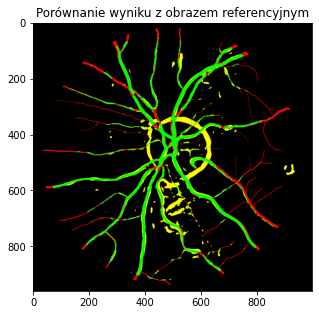

True positive:	45031	(zielony)
True negative:	866638	(czarny)
False positive:	25517	(żółty)
False negative:	21854	(czerwony)
Accuracy (trafność):		0.9506058141474808
Sensitivity (czułość):		0.6732600732600733
Specificity (swoistość):	0.9713984677550426
Balanced accuracy:		0.822329270507558
F1 score:			0.6553156810955156


In [150]:
(img, ref) = load("01L", False)

print("Metoda 1")
m1 = method_1(img, False)
analysis(m1, ref)

# Klasyfikator

In [ ]:
# def features(frag):
# #     hu_r = measure.moments_hu(frag[:,:,0])
# #     hu_g = measure.moments_hu(frag[:,:,1])
# #     hu_b = measure.moments_hu(frag[:,:,2])
# #     return hu_r + hu_g + hu_b 

#     r = frag[:,:,0].flatten()
#     g = frag[:,:,1].flatten()
#     b = frag[:,:,2].flatten()
    
# #     variant = [np.var(r), np.var(g), np.var(b)]
# #     return variant
#     moment = [stats.moment(r, 3), stats.moment(g, 3), stats.moment(b, 3)]
#     hu_r = measure.moments_hu(frag[:,:,0])
#     hu_g = measure.moments_hu(frag[:,:,1])
#     hu_b = measure.moments_hu(frag[:,:,2])
    
#     return moment + list(hu_r) + list(hu_g) + list(hu_b)
# #     hu_mean = list(np.mean(np.array([hu_r, hu_g, hu_b]), axis=0))

# #     return variant + moment + hu_mean

In [ ]:
def features(frag):
    return frag.flatten().flatten()

def features_2(frag):
    hu_r = measure.moments_hu(frag[:,:,0])
    hu_g = measure.moments_hu(frag[:,:,1])
    hu_b = measure.moments_hu(frag[:,:,2])
    moments = stats.moment(np.sum(frag, axis=2), 3)
    return list(hu_r) + list(hu_g) + list(hu_b) + list(moments)

def features_p(frag):
    hu_r = measure.moments_hu(frag[:,:,0])
    hu_g = measure.moments_hu(frag[:,:,1])
    hu_b = measure.moments_hu(frag[:,:,2])
    return list(filters.prewitt(rgb2gray(frag)).flatten()) + list(hu_r) + list(hu_g) + list(hu_b)

def features_pvh(frag):
    hu_r = measure.moments_hu(frag[:,:,0])
    hu_g = measure.moments_hu(frag[:,:,1])
    hu_b = measure.moments_hu(frag[:,:,2])
    return list(filters.prewitt_v(rgb2gray(frag)).flatten()) + list(filters.prewitt_h(rgb2gray(frag)).flatten()) + list(hu_r) + list(hu_g) + list(hu_b)

def before_retouch(img):
    img = exposure.adjust_gamma(img, 0.5)
    img = exposure.rescale_intensity(img)
    filtered = filters.gaussian(img, 3, multichannel=True)
    filtered = filters.unsharp_mask(img, 10)
    return filtered

In [ ]:
def check_if_only_zeros(listt):
    for item in listt:
        if item != 0:
            return False
    return True

def getTrainingDataFromImage( id, box=5 ):
    (img, ref) = load(id, False)
    img = before_retouch(img)
    (patches, refs) = get_picture_data(img, ref, box)
    feats = [features(f) for f in patches]

    print("feats before: ", len(feats))
    print(len(refs))

    indexesToRemove = []
    for i in range(len(feats)):
        if(check_if_only_zeros(feats[i]) ):
            indexesToRemove.append(i)

    indexesToRemove.pop(0)

    feats = np.delete(feats, indexesToRemove, axis=0)
    refs = np.delete(refs, indexesToRemove, axis=0)

    print("feats after: ", len(feats))
    return (feats, refs)

def getTrainingData( imgIdList, sampleCount, box=5 ):
    allFeats = []
    allRefs = []
    for imgId in imgIdList:
        print("Loading", imgId)
        (feats, refs) = getTrainingDataFromImage(imgId, box)
        allFeats += list(feats)
        allRefs += list(refs)
    
    return random.sample(list(zip(allFeats, allRefs)), sampleCount)

In [ ]:
#sample = getTrainingData(["01L", "01R", "02L", "02R", "03L", "03R", "04L", "04R"], 400000, 7)
sample = getTrainingData(["01L", "01R"], 400000, 7)

In [ ]:
clf = tree.DecisionTreeClassifier()

In [ ]:
clf.fit([f for f, _ in sample], [r for _, r in sample])

In [ ]:
import pickle

# Zapis klasyfikatora do pliku
pickle.dump(clf, open("clf", "wb"))

# Odczyt klasyfikatora z pliku
clf = pickle.load(open("clf", "rb"))

In [ ]:
def testfunction(estimator, id, box=5):
    (img, ref) = load(id, False)
    img = before_retouch(img)
    (patches, refs) = get_picture_data(img, ref, box)
    feats = [features(f) for f in patches]
    
    predicted = estimator.predict(feats)
    print('sum of predicted', sum(predicted))

    predicted_2d = np.reshape(predicted, (img.shape[0] - box + 1, img.shape[1] - box + 1))
    refs_2d = np.reshape(refs, (img.shape[0] - box + 1, img.shape[1] - box + 1))

    return (predicted_2d, refs_2d)

In [ ]:
(predicted_2d, ref_2d) = testfunction(clf, "05L", 7)
plt.imshow(predicted_2d)

In [ ]:
p2d = morphology.dilation(predicted_2d)
plt.imshow(p2d)

In [ ]:
analysis(p2d, ref_2d)

# Sieć neuronowa

In [260]:
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, ThresholdedReLU

In [261]:
def get_train_test_data(ids, sampleCount, test_size=0.33, box=5):
    allPatches = []
    allRefs = []
    for imgId in ids:
        print("Loading", imgId)
        (img, ref) = load(imgId, False)
        img = before_retouch(img)
        (patches, refs) = get_picture_data(img, ref, box)
        allPatches.append(patches)
        allRefs.append(refs)
        
    # Join data from all images
    allPatches = np.concatenate(allPatches, axis=0)
    allRefs = np.concatenate(allRefs, axis=0)
    
    # Delete data
    indexes = random.sample(range(allPatches.shape[0]), k=allPatches.shape[0] - sampleCount)
    allPatches = np.delete(allPatches, indexes, axis=0)
    allRefs = np.delete(allRefs, indexes, axis=0)
    
    print(allPatches.shape)
    print(allRefs.shape)
    
    return train_test_split(allPatches, allRefs, test_size=0.33)

In [262]:
x_train, x_test, y_train, y_test = get_train_test_data(["01L", "01R", "02L", "02R", "03L", "03R"], 800000)

Loading 01L
Loading 01R
Loading 02L
Loading 02R
Loading 03L
Loading 03R
(800000, 5, 5, 3)
(800000,)


In [265]:
model = Sequential()
model.add(Conv2D(64, 4, activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [266]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=128)

Epoch 1/5
4188/4188 [==============================] - 41s 9ms/step - loss: 0.2374 - binary_accuracy: 0.9221 - val_loss: 0.2039 - val_binary_accuracy: 0.9269
Epoch 2/5
4188/4188 [==============================] - 42s 10ms/step - loss: 0.2019 - binary_accuracy: 0.9281 - val_loss: 0.2010 - val_binary_accuracy: 0.9264
Epoch 3/5
4188/4188 [==============================] - 40s 9ms/step - loss: 0.1966 - binary_accuracy: 0.9287 - val_loss: 0.1943 - val_binary_accuracy: 0.9288
Epoch 4/5
4188/4188 [==============================] - 41s 10ms/step - loss: 0.1932 - binary_accuracy: 0.9297 - val_loss: 0.2051 - val_binary_accuracy: 0.9276
Epoch 5/5
4188/4188 [==============================] - 44s 10ms/step - loss: 0.1899 - binary_accuracy: 0.9314 - val_loss: 0.1932 - val_binary_accuracy: 0.9311


In [267]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Trafność klasyfikacji to: {acc}%".format(acc=accuracy*100)) 

8250/8250 [==============================] - 17s 2ms/step - loss: 0.1932 - binary_accuracy: 0.9311
Trafność klasyfikacji to: 93.11098456382751%


In [268]:
### Test

In [269]:
(img2, ref2) = load("04R", False)
img2 = before_retouch(img2)
(patches2, refs2) = get_picture_data(img2, ref2, 5)

In [270]:
pr = model.predict(patches2)

In [274]:
pr_2d = np.reshape(pr, (img2.shape[0] - 5 + 1, img2.shape[1] - 5 + 1))
pr_2d_th = pr_2d > 0.3
refs2_2d = np.reshape(refs2, (img2.shape[0] - 5 + 1, img2.shape[1] - 5 + 1))

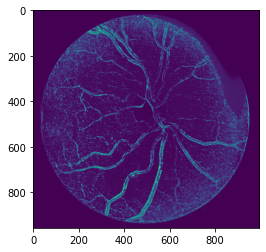

In [275]:
plt.imshow(pr_2d)

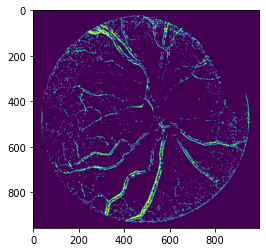

In [276]:
plt.imshow(pr_2d_th)

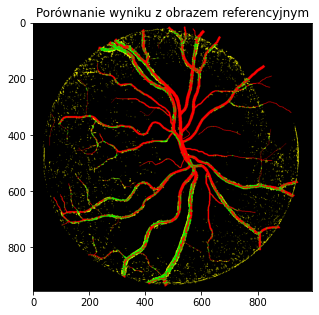

True positive:	19811	(zielony)
True negative:	856560	(czarny)
False positive:	20836	(żółty)
False negative:	54013	(czerwony)
Accuracy (trafność):		0.9213126300960871
Sensitivity (czułość):		0.26835446467273516
Specificity (swoistość):	0.9762524561315529
Balanced accuracy:		0.622303460402144
F1 score:			0.34613133457382217


In [277]:
analysis(pr_2d_th, refs2_2d)